In [2]:
import sqlite3

chembl_db_path = "/Users/family/Documents/ResearchProject/chembl_35/chembl_35_sqlite/chembl_35.db"

conn = sqlite3.connect(chembl_db_path)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables in the ChEMBL database:")
for table in tables:
    print(table[0])

conn.close()

Tables in the ChEMBL database:
action_type
assay_type
chembl_id_lookup
confidence_score_lookup
curation_lookup
chembl_release
source
relationship_type
target_type
variant_sequences
bioassay_ontology
data_validity_lookup
activity_smid
activity_stds_lookup
assay_classification
atc_classification
bio_component_sequences
component_sequences
protein_classification
domains
go_classification
structural_alert_sets
products
frac_classification
hrac_classification
irac_classification
research_stem
organism_class
patent_use_codes
usan_stems
version
cell_dictionary
docs
target_dictionary
tissue_dictionary
molecule_dictionary
activity_supp
component_class
component_domains
component_go
component_synonyms
structural_alerts
defined_daily_dose
product_patents
protein_class_synonyms
research_companies
assays
compound_records
binding_sites
biotherapeutics
compound_properties
compound_structural_alerts
compound_structures
molecule_atc_classification
molecule_frac_classification
molecule_hierarchy
molecul

In [3]:
import sqlite3
import pandas as pd

chembl_db_path = "/Users/family/Documents/ResearchProject/chembl_35/chembl_35_sqlite/chembl_35.db"
conn = sqlite3.connect(chembl_db_path)

query = """
SELECT 
    cs.canonical_smiles, 
    a.standard_type, 
    a.standard_value, 
    a.standard_units, 
    a.pchembl_value, 
    ass.description AS assay_description, 
    ass.assay_organism
FROM activities a
JOIN compound_structures cs ON a.molregno = cs.molregno
JOIN assays ass ON a.assay_id = ass.assay_id
WHERE ass.assay_organism = 'Homo sapiens'
AND a.standard_type IN ('IC50', 'EC50', 'pChEMBL')
ORDER BY a.standard_type;
"""

df = pd.read_sql_query(query, conn)
conn.close()

print(df.head())

                                    canonical_smiles standard_type  \
0     Cc1cn(C2C=CC(COC(=O)CN3CCNCC3)O2)c(=O)[nH]c1=O          EC50   
1                           CCCCCCCCCCCCNC(=O)C(N)CN          EC50   
2          Cc1cn([C@H]2C=C[C@@H](CO)O2)c(=O)[nH]c1=O          EC50   
3  CCOC(=O)/C=C/[C@H](CCC(N)=O)NC(=O)[C@H](Cc1ccc...          EC50   
4  O=S(=O)(O)c1cc(O)c2c(ccc3[nH]c(-c4ccc5ccccc5c4...          EC50   

   standard_value standard_units  pchembl_value  \
0           63.60             nM            NaN   
1         2511.89             nM           5.60   
2           90.00             nM           7.05   
3           33.00             nM           7.48   
4         9700.00             nM           5.01   

                                   assay_description assay_organism  
0  Effective concentration of compound achieving ...   Homo sapiens  
1  -log of the half-maximal concentration for sti...   Homo sapiens  
2  Effective concentration of compound achieving ...   Homo sa

In [4]:
import pandas as pd
import numpy as np

df_filtered = df[(df['standard_value'].notna()) & (df['canonical_smiles'].notna())]
df_filtered.loc[:, 'standard_value'] = pd.to_numeric(df_filtered['standard_value'], errors='coerce')
df_filtered = df_filtered[df_filtered['standard_units'] == 'nM']  
df_filtered = df_filtered[df_filtered['standard_value'] > 0]

def calculate_pchembl(row):
    if pd.notna(row['pchembl_value']):
        return row['pchembl_value']
    elif pd.notna(row['standard_value']):
        return -np.log10(row['standard_value'] / 1e9)
    else:
        return np.nan

df_filtered.loc[:, 'pchembl_value'] = df_filtered.apply(calculate_pchembl, axis=1)
df_filtered = df_filtered.drop_duplicates(subset=['canonical_smiles'])
df_filtered = df_filtered.reset_index(drop=True)

print(df_filtered.head())

                                    canonical_smiles standard_type  \
0     Cc1cn(C2C=CC(COC(=O)CN3CCNCC3)O2)c(=O)[nH]c1=O          EC50   
1                           CCCCCCCCCCCCNC(=O)C(N)CN          EC50   
2          Cc1cn([C@H]2C=C[C@@H](CO)O2)c(=O)[nH]c1=O          EC50   
3  CCOC(=O)/C=C/[C@H](CCC(N)=O)NC(=O)[C@H](Cc1ccc...          EC50   
4  O=S(=O)(O)c1cc(O)c2c(ccc3[nH]c(-c4ccc5ccccc5c4...          EC50   

   standard_value standard_units  pchembl_value  \
0           63.60             nM       7.196543   
1         2511.89             nM       5.600000   
2           90.00             nM       7.050000   
3           33.00             nM       7.480000   
4         9700.00             nM       5.010000   

                                   assay_description assay_organism  
0  Effective concentration of compound achieving ...   Homo sapiens  
1  -log of the half-maximal concentration for sti...   Homo sapiens  
2  Effective concentration of compound achieving ...   Homo sa

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

def generate_fingerprint(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)  
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fingerprint)

df_filtered['Fingerprints'] = df_filtered['canonical_smiles'].apply(generate_fingerprint)

print("Columns in df_filtered after adding Fingerprints:", df_filtered.columns)

In [ ]:
X_fingerprints = np.stack(df_filtered['Fingerprints'].values)

np.save("morgan_fingerprints.npy", X_fingerprints)
print("Morgan Fingerprints saved to 'morgan_fingerprints.npy'.")

In [5]:
X_fingerprints = np.load("morgan_fingerprints.npy")
df_filtered['Fingerprints'] = list(X_fingerprints)

print("Columns in df_filtered after reloading Fingerprints:", df_filtered.columns)

Columns in df_filtered after reloading Fingerprints: Index(['canonical_smiles', 'standard_type', 'standard_value', 'standard_units',
       'pchembl_value', 'assay_description', 'assay_organism', 'Fingerprints'],
      dtype='object')


In [6]:
other_features = df_filtered.drop(columns=['canonical_smiles', 'pchembl_value', 'Fingerprints']).values
global_features = np.hstack([other_features, X_fingerprints])

print("Shape of global_features after combining:", global_features.shape)

Shape of global_features after combining: (679269, 1029)


In [7]:
print(df_filtered.dtypes)
print(df_filtered.head())

non_numeric_columns = df_filtered.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

canonical_smiles      object
standard_type         object
standard_value       float64
standard_units        object
pchembl_value        float64
assay_description     object
assay_organism        object
Fingerprints          object
dtype: object
                                    canonical_smiles standard_type  \
0     Cc1cn(C2C=CC(COC(=O)CN3CCNCC3)O2)c(=O)[nH]c1=O          EC50   
1                           CCCCCCCCCCCCNC(=O)C(N)CN          EC50   
2          Cc1cn([C@H]2C=C[C@@H](CO)O2)c(=O)[nH]c1=O          EC50   
3  CCOC(=O)/C=C/[C@H](CCC(N)=O)NC(=O)[C@H](Cc1ccc...          EC50   
4  O=S(=O)(O)c1cc(O)c2c(ccc3[nH]c(-c4ccc5ccccc5c4...          EC50   

   standard_value standard_units  pchembl_value  \
0           63.60             nM       7.196543   
1         2511.89             nM       5.600000   
2           90.00             nM       7.050000   
3           33.00             nM       7.480000   
4         9700.00             nM       5.010000   

                          

In [8]:
import numpy as np
import pandas as pd

df_filtered = df_filtered.drop(columns=['canonical_smiles', 'assay_description'])

categorical_columns = ['standard_type', 'standard_units', 'assay_organism']
for col in categorical_columns:
    df_filtered[col] = pd.factorize(df_filtered[col])[0]  

df_filtered['Fingerprints'] = df_filtered['Fingerprints'].apply(lambda x: np.array(x) if isinstance(x, (list, np.ndarray)) and len(x) == 1024 else np.zeros(1024))

X_fingerprints = np.stack(df_filtered['Fingerprints'].values)
other_features = df_filtered.drop(columns=['pchembl_value', 'Fingerprints']).values
global_features = np.hstack([other_features, X_fingerprints])

print("Shape of global_features after combining:", global_features.shape)

Shape of global_features after combining: (679269, 1028)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("Standardizing global features before PCA...")
scaler = StandardScaler()
scaled_global_features = scaler.fit_transform(global_features)

print("Reducing global features to 5 dimensions using PCA...")
pca = PCA(n_components=5, random_state=42)
reduced_global_features = pca.fit_transform(scaled_global_features)

df_pca = pd.DataFrame(reduced_global_features, columns=[f"PCA_{i+1}" for i in range(5)])

df_filtered = pd.concat([df_filtered, df_pca], axis=1)

print("Global features reduced to 5 dimensions using PCA.")

Standardizing global features before PCA...


In [9]:
df_filtered.to_pickle("processed_data_with_pca.pkl")
print("Intermediate results saved to 'processed_data_with_pca.pkl'.")

Intermediate results saved to 'processed_data_with_pca.pkl'.


In [10]:
print(df_filtered['Fingerprints'].head())

empty_fingerprints = df_filtered[df_filtered['Fingerprints'].apply(lambda x: len(x) == 0)]
print(f"Number of rows with empty fingerprints: {len(empty_fingerprints)}")

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: Fingerprints, dtype: object
Number of rows with empty fingerprints: 0


Starting PCA computation...
PCA results saved to 'dataset_with_pca.csv'.
Starting t-SNE computation...
t-SNE results saved to 'dataset_with_tsne.csv'.


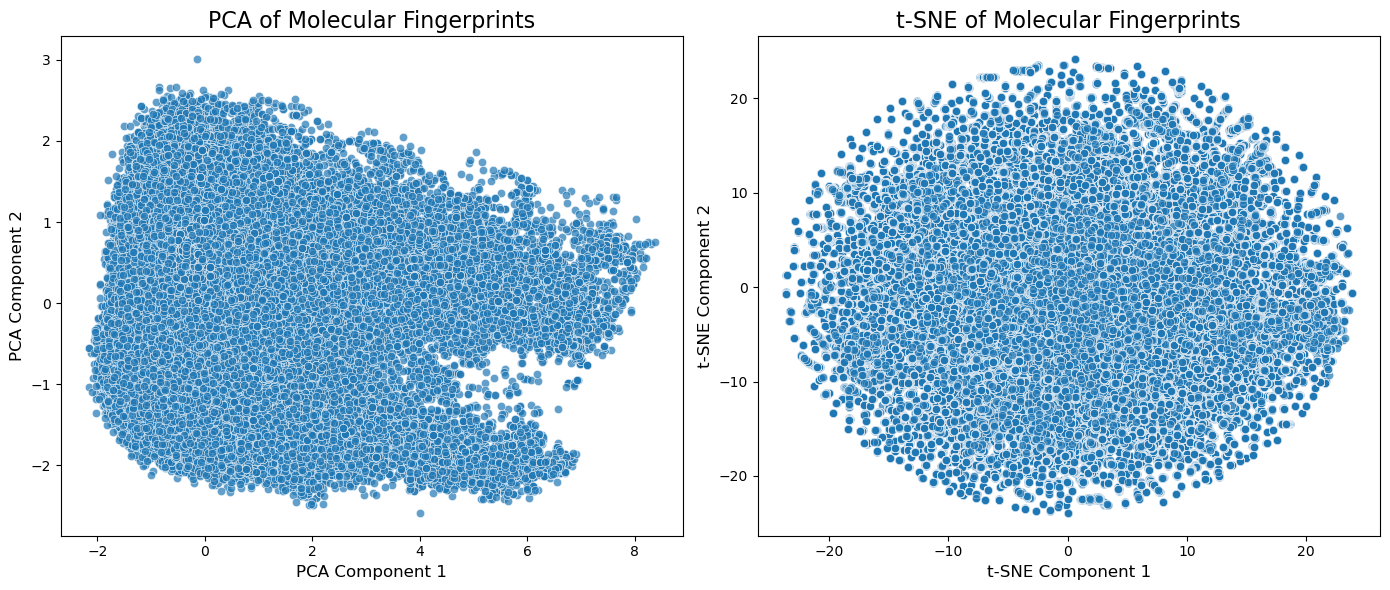

PCA and t-SNE visualizations saved to 'pca_tsne_visualizations.png'.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

X_fingerprints = np.stack(df_filtered['Fingerprints'].values)

print("Starting PCA computation...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_fingerprints)

df_filtered['PCA_1'] = X_pca[:, 0]
df_filtered['PCA_2'] = X_pca[:, 1]

df_filtered.to_csv("dataset_with_pca.csv", index=False)
print("PCA results saved to 'dataset_with_pca.csv'.")

print("Starting t-SNE computation...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_fingerprints)

df_filtered['tSNE_1'] = X_tsne[:, 0]
df_filtered['tSNE_2'] = X_tsne[:, 1]

df_filtered.to_csv("dataset_with_tsne.csv", index=False)
print("t-SNE results saved to 'dataset_with_tsne.csv'.")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='PCA_1', y='PCA_2', data=df_filtered, alpha=0.7)
plt.title('PCA of Molecular Fingerprints', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)

plt.subplot(1, 2, 2)
sns.scatterplot(x='tSNE_1', y='tSNE_2', data=df_filtered, alpha=0.7)
plt.title('t-SNE of Molecular Fingerprints', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)

plt.tight_layout()

plt.savefig("pca_tsne_visualizations.png", dpi=300, bbox_inches='tight')
plt.show()

print("PCA and t-SNE visualizations saved to 'pca_tsne_visualizations.png'.")

In [11]:
df_backup = pd.read_pickle("processed_data.pkl") #only processed_data.pkl consists of the Canonical_smiles(if i had to retrieve it anytime)
df_filtered['canonical_smiles'] = df_backup['canonical_smiles']  

print("Recovered 'canonical_smiles' from backup.")

Recovered 'canonical_smiles' from backup.


In [14]:
import torch
from torch_geometric.data import Data
from rdkit import Chem
import numpy as np

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),                          # Atomic Number
            atom.GetTotalDegree(),                        # Degree (Number of Bonds)
            atom.GetImplicitValence(),                    # Implicit Valency
            int(atom.GetIsAromatic()),                    # Aromaticity (Binary)
            atom.GetFormalCharge(),                       # Formal Charge
            atom.GetHybridization().real                  # Hybridization State (Enum to int)
        ]
        atom_features.append(features)

    x = torch.tensor(atom_features, dtype=torch.float)  

    edge_indices = []
    edge_features = []

    bond_type_dict = {
        Chem.rdchem.BondType.SINGLE: 0,
        Chem.rdchem.BondType.DOUBLE: 1,
        Chem.rdchem.BondType.TRIPLE: 2,
        Chem.rdchem.BondType.AROMATIC: 3
    }

    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()

        bond_features = [
            bond_type_dict.get(bond.GetBondType(), 0),  # Bond Type (Categorical)
            int(bond.GetIsConjugated()),                # Conjugation (Binary)
            int(bond.IsInRing()),                       # Ring Membership (Binary)
            bond.GetStereo().real                       # Stereochemistry
        ]

        edge_indices.append([start, end])
        edge_indices.append([end, start])  
        edge_features.append(bond_features)
        edge_features.append(bond_features)  

    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)  

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

graphs = []
failed_smiles = []  

for smiles in df_filtered['canonical_smiles']:
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graphs.append(graph)
    else:
        failed_smiles.append(smiles)

print(f" Successfully converted {len(graphs)} molecules into graphs.")
print(f"Failed to convert {len(failed_smiles)} molecules.")

torch.save(graphs, "molecule_graphs.pt")
torch.save(failed_smiles, "failed_smiles.pt")

print(" Graphs and failed SMILES saved successfully.")

 Successfully converted 679269 molecules into graphs.
Failed to convert 0 molecules.
 Graphs and failed SMILES saved successfully.


In [12]:
import torch
graphs = torch.load("molecule_graphs.pt", weights_only=False)

In [13]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler

df_filtered = df_filtered.drop(columns=['assay_description'], errors='ignore')

categorical_columns = ['standard_type', 'standard_units', 'assay_organism']
df_filtered[categorical_columns] = df_filtered[categorical_columns].apply(LabelEncoder().fit_transform)

df_filtered['Fingerprints'] = df_filtered['Fingerprints'].apply(lambda x: np.array(x, dtype=np.float32))

df_filtered.to_pickle("processed_data2.pkl")  
print(" Intermediate results saved to 'processed_data2.pkl'.")

fingerprint_features = np.vstack(df_filtered['Fingerprints'].dropna().values)

df_filtered_numeric = df_filtered.drop(columns=['canonical_smiles', 'pchembl_value', 'Fingerprints'], errors='ignore')
df_filtered_numeric = np.hstack((df_filtered_numeric.values, fingerprint_features))

scaler = StandardScaler()
global_features = scaler.fit_transform(df_filtered_numeric)

for i, graph in enumerate(graphs):
    graph.y = torch.tensor([df_filtered.iloc[i]['pchembl_value']], dtype=torch.float32)
    graph.global_features = torch.tensor(global_features[i], dtype=torch.float32)       

print(f" Added target values and global features to {len(graphs)} graphs.")


 Intermediate results saved to 'processed_data2.pkl'.
 Added target values and global features to 679269 graphs.


Models | GCN & GAT architectures 

In [6]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
import torch

class GCNModel(torch.nn.Module):
    def __init__(self, num_node_features, num_global_features, hidden_dim=64, dropout=0.3):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)  
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm(hidden_dim)  
        self.fc1 = torch.nn.Linear(hidden_dim + num_global_features, 64)
        self.fc2 = torch.nn.Linear(64, 1)

        self.dropout = dropout

    def forward(self, x, edge_index, batch, global_features):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  
        x = F.leaky_relu(x)  
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  
        x = F.leaky_relu(x)
        x = global_mean_pool(x, batch)  

        batch_size = batch.max().item() + 1 
        global_features = global_features.view(batch_size, -1)  
  

        print(f"Node features shape after pooling: {x.shape}")  
        print(f"Global features shape after fixing: {global_features.shape}")  

        x = torch.cat([x, global_features], dim=1)  
        x = F.leaky_relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)  
        x = self.fc2(x)

        return x.squeeze()


In [15]:
from torch_geometric.nn import GATConv

class GATModel(torch.nn.Module):
    def __init__(self, num_node_features, num_global_features, hidden_dim=64, heads=4, dropout=0.3):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_dim, heads=heads, dropout=dropout)
        self.bn1 = BatchNorm(hidden_dim * heads)  
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, dropout=dropout)
        self.bn2 = BatchNorm(hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim + num_global_features, 64)
        self.fc2 = torch.nn.Linear(64, 1)

        self.dropout = dropout

    def forward(self, x, edge_index, batch, global_features):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  

        x = global_mean_pool(x, batch)  

        batch_size = batch.max().item() + 1  
        global_features = global_features.view(batch_size, -1) 

        print(f"Node features shape after pooling: {x.shape}")  
        print(f"Global features shape after fixing: {global_features.shape}")  

        x = torch.cat([x, global_features], dim=1)  

        x = F.leaky_relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)  
        x = self.fc2(x)

        return x.squeeze()


In [1]:
import torch
graphs = torch.load("processed_graphs.pt")

/var/folders/gn/mtvnfy317_v0n6pjlh3w2gfc0000gn/T/ipykernel_6643/4039876705.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graphs = torch.load("processed_graphs.pt")


In [3]:
from torch_geometric.loader import DataLoader
import torch

torch.manual_seed(42) 
num_samples = len(graphs)

train_ratio, val_ratio, test_ratio = 0.8,0.1,0.1

train_size = int(train_ratio * num_samples)
val_size = int(val_ratio * num_samples)
test_size = num_samples - train_size - val_size 

train_graphs = graphs[:train_size]
val_graphs = graphs[train_size:train_size + val_size]
test_graphs = graphs[train_size + val_size:]

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_graphs)}")
print(f"Validation samples: {len(val_graphs)}")
print(f"Test samples: {len(test_graphs)}")


Train samples: 543415
Validation samples: 67926
Test samples: 67928
